In [570]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [571]:
class Conv2D:
    def __init__(self, n_filter, f_size, initializer, optimizer, activation, p =1, stride=1, n_channel_in = 1, n_channel_out= 1, debug = False):
        self.init = initializer
        self.optimizer = optimizer
        self.n_channel_in = n_channel_in
        self.n_channel_out = n_channel_out
        self.stride = stride
        self.pad = p
        self.n_out = None
        self.f_size = f_size
        self.activate = activation
        self.n_filter = n_filter
        self.debug = debug
    
    def forward(self, X):
        self.n_samples, im_rows, im_col = X.shape
        
        channels = self.n_channel_in
        X = X.reshape(self.n_samples, self.n_channel_in, im_rows, im_col)
        
        self.X = X
        # initialization of weights and biases
        self.w = self.init.W((self.n_channel_in, self.f_size, self.f_size))
        self.b = self.init.B((self.n_channel_in, 1))
        
        self.n_out_row = num_out(im_rows, self.pad, self.f_size, self.stride)
        self.n_out_col = num_out(im_col, self.pad, self.f_size, self.stride)

        result = np.zeros((self.n_samples, self.n_channel_in, self.n_out_row, self.n_out_col), dtype=np.float64)

        # padding of samples and kernel
        nx = im_rows + self.f_size - 1
        ny = im_col + self.f_size - 1

        self.x_new = np.pad(X, ((0, 0), (0, 0), (0, nx - im_rows), (0, ny - im_col)), mode="constant")
        self.w_new = np.pad(self.w, ((0, 0), (0, nx - self.f_size), (0, ny - self.f_size)))

        # loops through samples of images

        """convolution theorem states that under suitable conditions 
        the Fourier transform of a convolution of two functions (or signals) 
        is the pointwise product of their Fourier transforms."""

        for i in range(self.n_samples):
            sample = self.x_new[i]

            for ch in range(channels):
                channel = np.fft.fft2(sample[ch])
                weight = np.fft.fft2(self.w_new[ch])
                s = self.f_size - 2
                out = np.fft.ifft2(channel * weight)
                out = np.real(out)[s:-s:self.stride, s:-s:self.stride] + self.b[ch]
                
                result[i, ch] = out
        dA = result.sum(1)
        
        if self.debug:
            return dA
        
        return self.activate.forward(dA)

    
    def backward(self, dA):
        
        if not self.debug:
            dA = self.activate.backward(dA)
            
        dA = self.activate.backward(dA)
        self.dB = np.sum(dA, dtype=np.float64)

        dA = dA.reshape(self.X.shape)
        rows_da = dA.shape[-2]
        cols_da = dA.shape[-1]
        channels = dA.shape[1]
        n_samples, _, n_rows, n_cols = self.x_new.shape 

        nx = rows_da + n_rows - 1
        ny = cols_da + n_rows -1 

        dA_pad = np.pad(dA, ((0, 0), (0, 0), (0, nx - rows_da), (0, ny - cols_da)))
        x_pad = np.pad(self.x_new, ((0, 0), (0, 0), (0, nx - n_rows), (0, ny - n_cols)))

        d_x = rows_da - 1
        d_y = cols_da - 1
        w = np.ones((n_samples, channels, self.f_size, self.f_size))
        for i in range(n_samples):
            sample_da =  dA_pad[i]
            sample_x = x_pad[i]

            for ch in range(channels):
                layer_da = np.fft.fft2(sample_da[ch])
                layer_x = np.fft.fft2(sample_x[ch])

                c = np.fft.ifft2(layer_da * layer_x)
                c = np.real(c)[d_x:-d_x: self.stride, d_y: -d_y:self.stride]
                
                w[i, ch] = c
        
        self.dW = w.sum(0)

        dx = np.zeros((n_samples, channels, self.n_out_row, self.n_out_col))

        weights = self.w

        nx = rows_da + self.f_size - 1
        ny = cols_da + self.f_size - 1

        dA_pad = np.pad(dA, ((0, 0), (0, 0), (0, nx - rows_da), (0, ny - cols_da)), mode="constant")
        weights = np.pad(weights,((0, 0), (0, nx - self.f_size), (0, ny - self.f_size)), mode="constant")
        s = self.f_size - 2

        for i in range(n_samples):
            sample = dA_pad[i]
            for ch in range(channels):
                a = np.fft.fft2(sample[ch])
                b = np.fft.fft2(weights[ch])
                c = np.real(np.fft.ifft2(a*b))[s:-s:self.stride, s:-s:self.stride]
                
                dx[i, ch] = c
        
        self.optimizer.update(self)

        return dx
        

                

            

def num_out(n_in, pad, f, s):
    """
    ##### self.n_in: number of features
    ##### pad: Number of padding on one side
    ##### s: stride value

    ##### Returns: Number of output of convolution
    """
    n_out = ((n_in + 2*pad - f)/ s) +1
    return int(n_out)





In [572]:
class MaxPool2D():
    def __init__(self, P):
        self.P = P
        self.PA = None
        self.Pindex = None
    
    def forward(self,A):
        N,OH,OW = A.shape
        F = 1
        PH,PW = int(OH/self.P),int(OW/self.P)
        self.params = N,F,OH,OW,self.P,PH,PW
        self.PA = np.zeros([N,PH,PW])
        self.Pindex = np.zeros([N,PH,PW])
        for n in range(N):
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        #print(np.max(A[n,ch,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P]).shape)
                        self.PA[n,row,col] = np.max(A[n,row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
                        
                        self.Pindex[n,row,col] = np.argmax(A[n, row*self.P:row*self.P+self.P,col*self.P:col*self.P+self.P])
        
        return self.PA
    
    def backward(self,dA):
        N,F,OH,OW,PS,PH,PW = self.params
        dP = np.zeros([N,F,OH,OW])
        for n in range(N): 
            for ch in range(F):
                for row in range(PH):
                    for col in range(PW):
                        idx = self.Pindex[n,ch,row,col]
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            else:
                                tmp[i] = 0
                        dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
        return dP



In [573]:
class Flatten:
    def __init__(self):
        pass
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], -1)
    
    def backward(self,X):
        return X.reshape(self.shape)  

In [574]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activator):
        self.optimizer = optimizer
        self.w = initializer.W((n_nodes1, n_nodes2))
        self.b = initializer.B((n_nodes2,))
        self.activator = activator
        

        
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.Z = X
        A = X @ self.w + self.b
        
        return A
    
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        
        # update
        self.dB = np.sum(dA, axis=0)

       # print(self.dB)
        self.dW = self.Z.T @ dA 
        self.dZ = dA @ self.w.T
        
        self.optimizer.update(self)
        
        return self.dZ


In [575]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape):
        """
        Weight initialization
        Parameters
        ----------
        Shape: tuple
        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(*shape)
        
        return w
    
    def B(self, shape):
        """
        Bias initialization
        Parameters
        ----------
        shape : tuple
          Number of nodes in the later layer

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [576]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr 
        self.HW = 1
        self.HB = 1

    def update(self, layer):

        self.HW += layer.dW**2
        self.HB += layer.dB**2

        layer.w -= self.lr * np.sqrt(1/self.HW) * (layer.dW)
        layer.b -= self.lr * np.sqrt(1/self.HB) *  layer.dB


class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        The weight or bias of a certain layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """

        layer.w -= self.lr * layer.dW
        layer.b -= self.lr * layer.dB
    

In [577]:
class Relu:
    def __init__(self) -> None:
        pass

    def forward(self, X):
        self.A = X
        return np.clip(X, 0, None)
    
    def backward(self, X):
        a = X > 0
        return X * np.clip(np.sign(self.A), 0, None)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax():
        def __init__(self) -> None:
            pass


        def forward(self, a):
            numerator = np.exp(a)
            self.dZ = numerator / np.sum(np.exp(a), axis=1).reshape(-1, 1)
            return self.dZ
        
        def backward(self, Y):
             self.loss = self.loss_func(Y)   
                      
             return self.dZ - Y
        
        def loss_func(self, Y, Z = None):             
            if type(Z) == type(None):
                Z = self.dZ
            
            loss = -1* np.sum(Y * np.log(Z + 1e-7))

            return loss/len(Y)

            

In [578]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [579]:

class ScratchConvolutionalNeuralNetwork2D:
    def __init__(self, NN, CNN, epoch=20, batch_size=20, verbose = False):
        self.epoch = epoch
        self.NN = NN
        self.CNN = CNN
        self.batch_size = batch_size
        self.verbose = verbose
        self.log_loss = np.zeros(self.batch_size)
        self.log_acc = np.zeros(self.batch_size)

        
    def loss_function(self,y,yt):
        delta = 1e-7
        loss = - np.sum(yt * np.log(y + delta))

        return loss / len(yt)
    

    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)

    def fit(self, X, y, x_val = None, y_val= None):
        for epoch in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.loss = 0
            for mini_x_train, mini_y_train in get_mini_batch:
                # forward propagation
                forward_data = mini_x_train
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                
                
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)

                z = forward_data
                
                
            backward_data = (z- mini_y_train)/ self.batch_size
            layers = len(self.NN) - 1
            for layer in range(len(self.NN)):
                backward_data = self.NN[layers - layer].backward(backward_data)
            
            backward_data = flt.backward(backward_data)

            for layer in range(len(self.CNN)):
                backward_data = self.CNN[layer].backward(backward_data)
            
            self.loss += self.loss_function(z, mini_y_train)

            self.log_loss[epoch] = self.loss / self.batch_size
            self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))
            if self.verbose:
                print(self.loss/self.batch_size,self.accuracy(self.predict(X),np.argmax(y,axis=1)))

        return self

    def predict(self, X):
        pred_data = X[:, :, :]
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
            
        pred_data = Flatten().forward(pred_data)
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)

        return np.argmax(pred_data,axis=1)



In [580]:
class HeInitializer:
    def __init__(self, n):
        """
        n: Length of dataset
        """
        
        self.sigma = (2 / n) ** 0.5
        
    
    def W(self, nodes):
        return np.random.normal(0, self.sigma, nodes)
    
    def B(self, nodes):
        return np.random.normal(0, self.sigma, nodes)

In [581]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train.astype(np.float_), x_test.astype(np.float_)
x_train /= 255
x_test /= 255

onv = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
one_hot_y_train = onv.fit_transform(y_train[:, np.newaxis])
one_hot_y_test = onv.fit_transform(y_test[:, np.newaxis])

x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_y_train, test_size=0.3)




In [582]:
NN = {
    0:FC(784, 200, HeInitializer(784), AdaGrad(0.01), Relu()),
    1:FC(200, 200, HeInitializer(200), AdaGrad(0.01), Relu()),
    2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
}

CNN = {
    0: Conv2D(n_filter=10, n_channel_in=1, f_size=3, p=1, stride=1 ,initializer=SimpleInitializer(0.01),optimizer=SGD(0.01), activation = Relu())
    #1:MaxPool2D(2),
}

model = ScratchConvolutionalNeuralNetwork2D(NN=NN, CNN=CNN).fit(x_train, y_train)

C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Local\Temp\ipykernel_25940\1162421311.py:14: RuntimeWarning: invalid value encountered in log
  loss = - np.sum(yt * np.log(y + delta))
C:\Users\Sylvanus\AppData\Lo

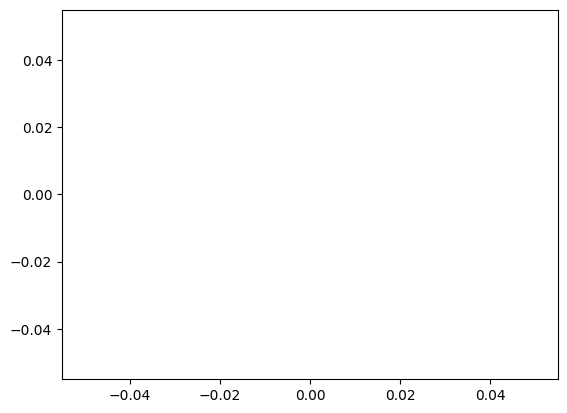

In [584]:
plt.plot(model.log_loss)

In [587]:
accuracy_score(y_test, model.predict(x_test))

0.0905